# Systems Identification Model Fitting

Fit a Systems Identification model off based off of this [specification](https://hackmd.io/w-vfdZIMTDKwdEupeS3qxQ) and [spec](https://hackmd.io/XVaejEw-QaCghV1Tkv3eVQ) with data obtained in [data_acquisition.ipynb](data/data_acquisition.ipynb).

## Analyze and Prepare Data

In [342]:
# import libraries
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

states = pd.read_csv('states.csv')
del states['Unnamed: 0']
states.head()

,marketPriceEth,marketPriceUsd,block_number,debtAvailableToSettle,globalDebt,globalDebtCeiling,systemSurplus,totalActiveSafeCount,RedemptionRateAnnualizedRate,RedemptionRateHourlyRate,RedemptionRateEightHourlyRate,RedemptionPrice,EthInUniswap,RaiInUniswap,RaiDrawnFromSAFEs,collateral,debt,ETH Price (OSM)
0,0.000858,3.051840,12388143.0,0.0,2.632464e+07,1.157921e+32,230002.364951,583.0,0.978704,0.999998,0.99998,3.005443,11977.048864,1.389236e+07,2.601571e+07,1249.4226,293469.366076,3521.749280
1,0.000858,3.051840,12387897.0,0.0,2.632464e+07,1.157921e+32,230002.364951,583.0,0.978704,0.999998,0.99998,3.005450,12025.302340,1.383645e+07,2.601571e+07,1249.4226,293469.366076,3484.967617
2,0.000869,3.060763,12387633.0,0.0,2.629462e+07,1.157921e+32,229927.716817,583.0,0.978704,0.999998,0.99998,3.005465,12033.680708,1.382679e+07,2.598571e+07,1249.4226,293469.366076,3509.940000
3,0.000870,3.051668,12387345.0,0.0,2.629462e+07,1.157921e+32,229927.716817,583.0,0.978704,0.999998,0.99998,3.005465,12033.680708,1.382679e+07,2.598571e+07,1249.4226,293469.366076,3438.463957
4,0.000875,3.043224,12387095.0,0.0,2.629407e+07,1.157921e+32,229903.041060,583.0,0.978704,0.999998,0.99998,3.005472,12080.165571,1.377424e+07,2.598521e+07,1249.4226,293469.366076,3464.125574


In [343]:
# save block numbers
blockNumbers = states.block_number.values

In [344]:
states['RedemptionPriceinEth'] = states['RedemptionPrice'] / states['ETH Price (OSM)']

## TODO
1. Coordinate transform - subtract means?
2. Use SVAR or VARMAX - pass in equality contraints - How to pass equality contraints into VAR, SVAR or VARMAX. (Primal dual method -- solve the kkt equations(overkill method)).
3. Fully document

### Mapping of specification states to data

#### Initial vector - will probably add slack variables 
The quantity state variables of the system are:
* ETH in collateral = $Q$ = collateral
* ETH in Uniswap = $R_{ETH}$ reserve1
* RAI in Uniswap = $R_{RAI}$ = reserve0 
* RAI drawn from SAFEs = $D$ = erc20CoinTotalSupply


GlobalDebt won't equal total supply (create graphics around?)

The metric state variables of the system are:

* Market Price of RAI in ETH = marketPriceEth
* Market Price of RAI in USD = marketPriceUsd
* Market Price of ETH in USD = ETH Price (OSM)

The metric control variables of the system are:

* Redemption Price of RAI in USD = RedemptionPrice
* Redemption Price of RAI in ETH = RedemptionPriceinEth 

### Model Formulation


There is an admissible action set of vectors:

* ETH in collateral = $Q$ = collateral
* ETH in Uniswap = $R_{ETH}$ reserve1
* RAI in Uniswap = $R_{RAI}$ = reserve0 
* RAI drawn from SAFEs = $D$ = erc20CoinTotalSupply



Action vector: $\vec{u} = (\Delta Q, \Delta R_{ETH}, \Delta R_{RAI}, \Delta D)$

Admissible action set: $\vec{u} \in \mathcal{U}$

Optimal Action Vector: $\vec{u^*} = (Q^*, R_{ETH}^*, \Delta R_{RAI}^*, \Delta D^*)$


## Create model

In [345]:
# # manual univariate autoregressor 
# def univariate_identification(states_df,state):
#     '''
#     Function to create systems identification model
    
#     Parameters:
#     states_df: Pandas dataframe with states information
#     state: string of state name
    
#     returns fitted_model
#     '''
#     univariate_state = states_df[[state]]
#     univariate_state['delta'] = univariate_state.diff()
#     univariate_state['posterior'] = univariate_state[state] + univariate_state['delta']
#     univariate_state['Y_state_change'] = univariate_state.delta.shift(-1)
#     univariate_state.dropna(inplace=True)
#     print('DataFrame Head')
#     print(univariate_state.head(10))
#     print('\n DataFrame Tail')
#     print(univariate_state.tail(10))
    
#     # create model
#     split_point = int(len(univariate_state) * .8)
#     train = univariate_state.iloc[0:split_point]
#     test = univariate_state.iloc[split_point:]
    
#     Y = train['Y_state_change']
#     X = train[[state,'delta','posterior']]
    
#     model = sm.OLS(Y,X)

#     fitted_model = model.fit_regularized(method='sqrt_lasso')
#     fitted_model = model.fit()
#     print('\n Model Parameters')
#     print(fitted_model.params)
    
#     Y_test = test['Y_state_change']
#     X_test = test[[state,'delta','posterior']]
#     predicted = fitted_model.predict(X_test)
#     print('\n Model RMSE:')
#     print(sm.tools.eval_measures.rmse(Y_test, predicted, axis=0))
    
#     return fitted_model

# marketPriceEth_model = univariate_identification(states,'marketPriceEth')

In [346]:
# Create action vector
V = states[['collateral','EthInUniswap','RaiInUniswap','RaiDrawnFromSAFEs']]
V_diff = V.diff().iloc[1:-5]
V_diff.fillna(0,inplace=True)

In [347]:
# split data between train and test
split_point = int(len(V_diff) * .8)
V_diff_train = V_diff.iloc[0:split_point]
V_diff_test = V_diff.iloc[split_point:]

The un-transformed training data looks as the following:

array([[<AxesSubplot:title={'center':'collateral'}>,
        <AxesSubplot:title={'center':'EthInUniswap'}>],
       [<AxesSubplot:title={'center':'RaiInUniswap'}>,
        <AxesSubplot:title={'center':'RaiDrawnFromSAFEs'}>]], dtype=object)

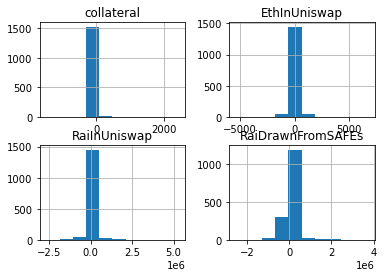

In [348]:
V_diff_train.hist()

### Coordinate transformation

For our initial coordinate transformation, we will use the Yeo-Johnson power transformation. The Yeo-Johnson power transformation is used to stabilize variance, and make data more Gausian. The Yeo-Johnson is an extension of Box-Cox that allows for both zero and negative values; and is derived as follows:

$$
y_i^{(\lambda)} = \begin{cases} ((y_i+1)^\lambda-1)/\lambda                      &  \text{if }\lambda \neq 0, y \geq 0 \\ 
                                \log(y_i + 1)                                    &  \text{if }\lambda =    0, y \geq 0 \\ 
                                -[(-y_i + 1)^{(2-\lambda)} - 1] / (2 - \lambda)  &  \text{if }\lambda \neq 2, y <    0 \\ 
                                -\log(-y_i + 1)                                  &  \text{if }\lambda =    2, y <    0 
                  \end{cases}
$$

Scikit-learn has a great implementation of the transformer, which we will use below.

In [349]:
pt = PowerTransformer(method='yeo-johnson')
V_transformed_train = pt.fit_transform(V_diff_train)
V_transformed_test = pt.fit_transform(V_diff_test)

Below we will analyze the resulting data:

array([[<AxesSubplot:title={'center':'collateral'}>,
        <AxesSubplot:title={'center':'EthInUniswap'}>],
       [<AxesSubplot:title={'center':'RaiInUniswap'}>,
        <AxesSubplot:title={'center':'RaiDrawnFromSAFEs'}>]], dtype=object)

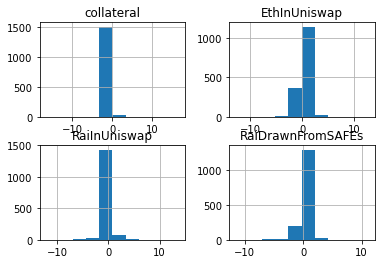

In [350]:
pd.DataFrame(V_transformed_train,columns=V_diff_train.columns).hist()

In [351]:
pd.DataFrame(V_transformed_train,columns=V_diff_train.columns).describe()

,collateral,EthInUniswap,RaiInUniswap,RaiDrawnFromSAFEs
count,1.552000e+03,1.552000e+03,1.552000e+03,1.552000e+03
mean,-5.025691e-16,-3.548135e-17,3.376451e-17,-9.871828e-17
std,1.000322e+00,1.000322e+00,1.000322e+00,1.000322e+00
min,-1.649333e+01,-1.288168e+01,-1.214324e+01,-1.158230e+01
25%,-3.294339e-03,-1.036273e-01,-1.274686e-01,-3.923158e-02
50%,-3.294339e-03,-3.293767e-02,5.654182e-02,4.645820e-02
75%,-3.294339e-03,1.113920e-01,1.282406e-01,7.005397e-02
max,1.662650e+01,1.267050e+01,1.373340e+01,1.107567e+01


In [352]:
np.isfinite(pd.DataFrame(V_transformed_train,columns=V_diff_train.columns)).describe()

,collateral,EthInUniswap,RaiInUniswap,RaiDrawnFromSAFEs
count,1552,1552,1552,1552
unique,1,1,1,1
top,True,True,True,True
freq,1552,1552,1552,1552


Potential alternative transformations are as follows:

* sin
* log of the Yeo-Johnson

Both of which provide a better fit than the Yeo-Johnson (as seen below).


For the rest of this notebook, we will implement the model training, forecasting, and evaluation process which will allow us to iterate over different transformations until we find one that fits our use case the best.

array([[<AxesSubplot:title={'center':'collateral'}>,
        <AxesSubplot:title={'center':'EthInUniswap'}>],
       [<AxesSubplot:title={'center':'RaiInUniswap'}>,
        <AxesSubplot:title={'center':'RaiDrawnFromSAFEs'}>]], dtype=object)

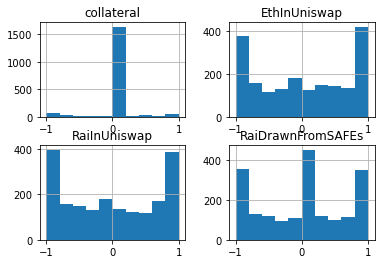

In [353]:
np.sin(V_diff).hist()

In [ ]:
np.log(pd.DataFrame(V_transformed_train,columns=V_diff_train.columns)).hist()

### Autogressive lag selection

In [ ]:
aic = []
for i in range(1,16):
    model = VAR(V_transformed_train)
    results = model.fit(i,ic='aic')
    aic.append(results.aic)
    
    
plt.figure(figsize=(10, 8))
plt.plot(aic, 'r+')
plt.legend(['AIC'])
plt.xlabel('Autocorrelation Lag')
plt.ylabel('AIC')
plt.title('Plot of sweeps over lag depths over AIC Loss functions')
plt.show()

Given a set of candidate models for the data, **the preferred model is the one with the minimum AIC value, the sign of the data does not matter**. AIC optimizes for goodness of fit but also includes a penalty for each additional parameter, which discourages overfitting. In our case, this appears that a lag of ***9*** is optimal.


In [ ]:
# instantiate the var model object from statsmodels
model = VAR(V_transformed_train)

# fit model with determined lag values
results = model.fit(9)
results.summary()

In [ ]:
# convert 5 test rows back into diff values
Y_test = pt.inverse_transform(V_transformed_test[:5])

In [ ]:
# create a 5 step prediction and convert back to diffs
Y_pred = pt.inverse_transform(results.forecast(V_transformed_train[-results.k_ar:], 5))


In [ ]:
Y_test[0]

In [ ]:
Y_pred[0]

### Univarate model performance validation

In [ ]:
sm.tools.eval_measures.rmse(Y_test[:,0], Y_pred[:,0], axis=0)

In [ ]:
sm.tools.eval_measures.rmse(Y_test[:,1], Y_pred[:,1], axis=0)

In [ ]:
sm.tools.eval_measures.rmse(Y_test[:,2], Y_pred[:,2], axis=0)

In [ ]:
sm.tools.eval_measures.rmse(Y_test[:,3], Y_pred[:,3], axis=0)

In [ ]:
Y_pred[:,3]

In [ ]:
Y_test[:,3]

The errors are rather high, but we are dealing with some very wide swings in the data. Alternative transformations need to be explored.

## Conclusion